<a href="https://colab.research.google.com/github/jason5306/SRS-Jigsaw-Puzzle-Solver/blob/main/Notebook2_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Tweets Data 


1.   Import Tweets from sntwitter API (https://github.com/JustAnotherArchivist/snscrape)

2.   Clean up data - Remove special characters, emojis, memes in each tweets

In [1]:
import numpy as np
import pandas as pd
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
import matplotlib.pyplot as mlpt
import csv
!pip install snscrape
import datetime as dt
import snscrape.modules.twitter as sntwitter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
tweets = []
# Using TwitterSearchScraper to scrape data and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('#Black Lives Matter  since:2022-01-01','corona lang:en').get_items()):
    tweets.append([tweet.date,  tweet.content])

In [3]:
tweets = pd.DataFrame(tweets, columns=['Date', 'Tweets'])
tweets

,Date,Tweets
0,2022-09-08 09:30:56+00:00,Black Woman SVG - Black Girl Magic SVG - Black...
1,2022-09-08 07:14:47+00:00,Black Woman SVG - Black Girl Magic SVG - Black...
2,2022-09-08 05:27:16+00:00,@footbaIItheory @DeadlineDayLive #Black lives ...
3,2022-09-08 01:51:19+00:00,Black Woman SVG - Black Girl Magic SVG - Black...
4,2022-09-07 17:21:55+00:00,Black Woman SVG - Black Girl Magic SVG - Black...
...,...,...
1034,2022-01-03 00:15:50+00:00,Dedicated to Desmond Tutu | Humans - via @pens...
1035,2022-01-02 08:09:47+00:00,Dedicated to Desmond Tutu | Humans - via @pens...
1036,2022-01-02 00:06:53+00:00,Dedicated to Desmond Tutu | Humans - via @pens...
1037,2022-01-01 13:04:11+00:00,"Here, Glenn Loury addresses Black Lives Matter..."


In [4]:
data=tweets
cdata=pd.DataFrame(columns=['Date','Tweets'])
index=0
for index,row in data.iterrows():
    stre=row["Tweets"]
    #the following cleaning steps are not the standard. You may generate your own ways of cleaning.
    my_new_string = re.sub('#\w+', '', stre) #remove the hashtags
    my_new_string = re.sub('http\S+', '', my_new_string) #remove the links
    my_new_string = re.sub('\n', '', my_new_string) #remove \n
    cdata.sort_index()
    cdata.at[index,'Date']=row["Date"]
    cdata.at[index,'Tweets']=my_new_string
    index=index+1
tweets=cdata
tweets['Date'] = tweets['Date'].astype('datetime64[ns]')
tweets["Date"]=tweets["Date"].dt.date

In [5]:
tweets.head()

,Date,Tweets
0,2022-09-08,Black Woman SVG - Black Girl Magic SVG - Black...
1,2022-09-08,Black Woman SVG - Black Girl Magic SVG - Black...
2,2022-09-08,@footbaIItheory @DeadlineDayLive lives matter
3,2022-09-08,Black Woman SVG - Black Girl Magic SVG - Black...
4,2022-09-07,Black Woman SVG - Black Girl Magic SVG - Black...


#Sentiment Analysis for Tweets

Sentiment Analysis is a process of ‘computationally’ evaluating whether a piece of text is positive, negative or neutral. In our case, conducting sentiment analysis on tweets help determine the public's moods towards BLM(Black Lives Matter) topic.
1.   **VADER (Valence Aware Dictionary and Entiment Reasoner)** https://github.com/cjhutto/vaderSentiment

```
"VADER is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed
in social media. A sentiment lexicon is a list of lexical features (e.g., words) which are generally labeled
according to their semantic orientation aseither positive or negative. VADER not only tells about the Positivity
and Negativity score but also tells us about how positive or negative a sentiment is." (GreeksforGreeks)
```
2.   **Reference**
 
  Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

In [6]:
!pip install vaderSentiment
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 5.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 37 kB/s 
     |████████████████████████████████| 199 kB 47.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=38ef4f99d684919077208c07df08079d15b8d2a017c0ac24d9ae835fa66468dc
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [7]:
import pyspark as spark
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from pyspark.sql.types import *
from pyspark.sql import SQLContext
from pyspark.sql.functions import col,udf,monotonically_increasing_id,unix_timestamp,round,avg
import re
sc = spark.SparkContext()
sql = spark.SQLContext(sc)

In [8]:
FullDataTw=sql.createDataFrame(tweets)
FullDataTw = FullDataTw.dropna()
FullDataTw.select(monotonically_increasing_id().alias("rowId"),"*")
 #setting column names of Twitter dataset
CleanDF = FullDataTw.withColumnRenamed('Tweets', 'Tweet')
CleanDF = FullDataTw.withColumnRenamed('Date', 'Date_Time')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
def senti_score_udf(sentence):
    snt = analyser.polarity_scores(sentence)
    return ([snt['neg'], snt['neu'], snt['pos'], snt['compound']])
func_udf2 = udf(senti_score_udf, ArrayType(FloatType()))
CleanDF = CleanDF.withColumn('p_neg', func_udf2(CleanDF['Tweets'])[0])  #withColumn function would generate the result with a new column name
CleanDF = CleanDF.withColumn('p_neu', func_udf2(CleanDF['Tweets'])[1])
CleanDF = CleanDF.withColumn('p_pos', func_udf2(CleanDF['Tweets'])[2])
CleanDF = CleanDF.withColumn('p_comp', func_udf2(CleanDF['Tweets'])[3])
CleanDF.show(120)
CleanDF.toPandas().to_csv('sen.csv',index=False)

+----------+--------------------+-----+-----+-----+-------+
| Date_Time|              Tweets|p_neg|p_neu|p_pos| p_comp|
+----------+--------------------+-----+-----+-----+-------+
|2022-09-08|Black Woman SVG -...|  0.0|0.952|0.048| 0.0258|
|2022-09-08|Black Woman SVG -...|  0.0|0.942|0.058| 0.0258|
|2022-09-08|@footbaIItheory @...|  0.0|0.732|0.268| 0.0258|
|2022-09-08|Black Woman SVG -...|  0.0|0.952|0.048| 0.0258|
|2022-09-07|Black Woman SVG -...|  0.0|0.952|0.048| 0.0258|
|2022-09-07|Black Woman SVG -...|  0.0|0.942|0.058| 0.0258|
|2022-09-06| folks are murder...|0.159|0.772|0.069| -0.505|
|2022-09-06|Black Lives Matte...|  0.0| 0.82| 0.18| 0.0516|
|2022-09-06|Black Woman SVG -...|  0.0|0.942|0.058| 0.0258|
|2022-09-06|Black Woman SVG -...|  0.0|0.952|0.048| 0.0258|
|2022-09-06|Black Woman SVG -...|  0.0|0.942|0.058| 0.0258|
|2022-09-06|Black Lives Matte...|  0.0| 0.82| 0.18| 0.0516|
|2022-09-05|Black Lives Matte...|  0.0| 0.82| 0.18| 0.0516|
|2022-09-05|Black Woman SVG -...|  0.0|0

 **Categorize Sentiments**
Once getting the compound sentiment score for each Tweets, we put them into categories. 


  $$Negative \ Sentiment : -0.9<P_{comp}\leq -0.05$$
   
  $$Positive\  Sentiment: 0.05\leq P_{comp}<0.9$$

  $$Neutral \ Sentiment:  -0.05<P_{comp}<0.05 $$

  $$Extremely\ Negative \ Sentiment:  P_{comp}\leq -0.9 $$

  $$Extremely\ Postive \ Sentiment:  P_{comp}\geq 0.9 $$

In [9]:
tw=pd.read_csv("sen.csv")
tw["length"]=""
i=0
# iterate through the csv file 
for val in tw["Tweets"]: 
  val = str(val) 
  tokens = val.split() 
  tw["length"][i]=len(tokens)
  i=i+1
tw=tw.drop(columns=["p_neg","p_neu","p_pos"])

In [10]:
tw.loc[(tw['p_comp']>-0.05)&(tw['p_comp']<0.05),'sentiment']="neutral"
tw.loc[(tw['p_comp']>=0.05)&(tw['p_comp']<0.9),'sentiment']='positive'
tw.loc[(tw['p_comp']<=-0.05)&(tw['p_comp']>-0.9),'sentiment']='negative'
tw.loc[tw['p_comp']<=-0.9,'sentiment']='extremely negative'
tw.loc[tw['p_comp']>=0.9,'sentiment']='extremely positive'
tw

,Date_Time,Tweets,p_comp,length,sentiment
0,2022-09-08,Black Woman SVG - Black Girl Magic SVG - Black...,0.0258,20,neutral
1,2022-09-08,Black Woman SVG - Black Girl Magic SVG - Black...,0.0258,19,neutral
2,2022-09-08,@footbaIItheory @DeadlineDayLive lives matter,0.0258,4,neutral
3,2022-09-08,Black Woman SVG - Black Girl Magic SVG - Black...,0.0258,20,neutral
4,2022-09-07,Black Woman SVG - Black Girl Magic SVG - Black...,0.0258,20,neutral
...,...,...,...,...,...
1034,2022-01-03,Dedicated to Desmond Tutu | Humans - via @pens...,0.4588,9,positive
1035,2022-01-02,Dedicated to Desmond Tutu | Humans - via @pens...,0.4588,9,positive
1036,2022-01-02,Dedicated to Desmond Tutu | Humans - via @pens...,0.4588,9,positive
1037,2022-01-01,"Here, Glenn Loury addresses Black Lives Matter...",-0.9231,30,extremely negative


# Exercise2

#### Crawl data from twitter with another topic and do sentiment analysis on the data, after you get the results, try to use graphs to visualize the sentiment analysis results (any type of graph that could satisfy your purpose)

In [13]:
tweets = []
# Using TwitterSearchScraper to scrape data and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('#duke since:2022-05-15 until:2022-08-31 min_faves:3','corona lang:en').get_items()):
    tweets.append([tweet.date,  tweet.content])

In [14]:
tweets = pd.DataFrame(tweets, columns=['Date', 'Tweets'])
tweets

,Date,Tweets
0,2022-08-30 23:54:07+00:00,2nd of the day .....\n\n'24 Page (TN) O-linema...
1,2022-08-30 23:19:41+00:00,給油量2トン超えました\n#ktm #duke https://t.co/HGp77SwxF8
2,2022-08-30 22:41:27+00:00,@SpencerJCox @LesaPamplin Now that this has be...
3,2022-08-30 18:23:10+00:00,This is an abomination #utah #BYU. The volleyb...
4,2022-08-30 14:48:30+00:00,Sharing my thoughts on @rolandsmartin #rolandm...
...,...,...
829,2022-05-16 16:21:59+00:00,ちょっと近所の岡山ドームまで\nお客様方とナイトツーリングに\n行ってきました🏍💨\n\n#...
830,2022-05-16 10:02:37+00:00,There will be good news this weekend on our NF...
831,2022-05-16 09:49:19+00:00,【🎁お裾分け🎁】\n昨日の『Distinct Musics 〜それぞれのgood music...
832,2022-05-15 16:36:35+00:00,"SIPP now -13% YTD, small adds to #LIO #MRCH ca..."


In [15]:
data=tweets
cdata=pd.DataFrame(columns=['Date','Tweets'])
index=0
for index,row in data.iterrows():
    stre=row["Tweets"]
    #the following cleaning steps are not the standard. You may generate your own ways of cleaning.
    my_new_string = re.sub('#\w+', '', stre) #remove the hashtags
    my_new_string = re.sub('http\S+', '', my_new_string) #remove the links
    my_new_string = re.sub('\n', '', my_new_string) #remove \n
    cdata.sort_index()
    cdata.at[index,'Date']=row["Date"]
    cdata.at[index,'Tweets']=my_new_string
    index=index+1
tweets=cdata
tweets['Date'] = tweets['Date'].astype('datetime64[ns]')
tweets["Date"]=tweets["Date"].dt.date

In [16]:
tweets.head()

,Date,Tweets
0,2022-08-30,2nd of the day .....'24 Page (TN) O-lineman re...
1,2022-08-30,給油量2トン超えました
2,2022-08-30,@SpencerJCox @LesaPamplin Now that this has be...
3,2022-08-30,This is an abomination . The volleyball match...
4,2022-08-30,Sharing my thoughts on @rolandsmartin on the ...


In [21]:
FullDataTw=sql.createDataFrame(tweets)
FullDataTw = FullDataTw.dropna()
FullDataTw.select(monotonically_increasing_id().alias("rowId"),"*")
 #setting column names of Twitter dataset
CleanDF = FullDataTw.withColumnRenamed('Tweets', 'Tweet')
CleanDF = FullDataTw.withColumnRenamed('Date', 'Date_Time')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
def senti_score_udf(sentence):
    snt = analyser.polarity_scores(sentence)
    return ([snt['neg'], snt['neu'], snt['pos'], snt['compound']])
func_udf2 = udf(senti_score_udf, ArrayType(FloatType()))
CleanDF = CleanDF.withColumn('p_neg', func_udf2(CleanDF['Tweets'])[0])  #withColumn function would generate the result with a new column name
CleanDF = CleanDF.withColumn('p_neu', func_udf2(CleanDF['Tweets'])[1])
CleanDF = CleanDF.withColumn('p_pos', func_udf2(CleanDF['Tweets'])[2])
CleanDF = CleanDF.withColumn('p_comp', func_udf2(CleanDF['Tweets'])[3])
CleanDF.show(120)
CleanDF.toPandas().to_csv('sen2.csv',index=False)

+----------+-------------------------------------+-----+-----+-----+-------+
| Date_Time|                               Tweets|p_neg|p_neu|p_pos| p_comp|
+----------+-------------------------------------+-----+-----+-----+-------+
|2022-08-30|                 2nd of the day .....|  0.0|  1.0|  0.0|    0.0|
|2022-08-30|              給油量2トン超えました  |  0.0|  1.0|  0.0|    0.0|
|2022-08-30|                 @SpencerJCox @Les...| 0.16|0.798|0.043|-0.5859|
|2022-08-30|                 This is an abomin...|0.213|0.735|0.052|-0.8402|
|2022-08-30|                 Sharing my though...|0.207|0.718|0.074|-0.7177|
|2022-08-30|                 NEW ⁦@TheAthletic...|  0.0|  1.0|  0.0|    0.0|
|2022-08-30|                 Beautiful and eff...|  0.0|0.731|0.269| 0.7906|
|2022-08-30|                 Can a  be a knigh...|  0.0|0.855|0.145|  0.296|
|2022-08-30|                 &amp; for the rec...|0.032|0.815|0.153| 0.6542|
|2022-08-30|                 @CriddleBenjamin ...|  0.0|0.549|0.451| 0.6249|
|2022-08-

In [19]:
tw=pd.read_csv("sen2.csv")
tw["length"]=""
i=0
# iterate through the csv file 
for val in tw["Tweets"]: 
  val = str(val) 
  tokens = val.split() 
  tw["length"][i]=len(tokens)
  i=i+1
tw=tw.drop(columns=["p_neg","p_neu","p_pos"])

In [22]:
tw.loc[(tw['p_comp']>-0.05)&(tw['p_comp']<0.05),'sentiment']="neutral"
tw.loc[(tw['p_comp']>=0.05)&(tw['p_comp']<0.9),'sentiment']='positive'
tw.loc[(tw['p_comp']<=-0.05)&(tw['p_comp']>-0.9),'sentiment']='negative'
tw.loc[tw['p_comp']<=-0.9,'sentiment']='extremely negative'
tw.loc[tw['p_comp']>=0.9,'sentiment']='extremely positive'
tw

,Date_Time,Tweets,p_comp,length,sentiment
0,2022-08-30,2nd of the day .....'24 Page (TN) O-lineman re...,0.0000,14,neutral
1,2022-08-30,給油量2トン超えました,0.0000,1,neutral
2,2022-08-30,@SpencerJCox @LesaPamplin Now that this has be...,-0.5859,29,negative
3,2022-08-30,This is an abomination . The volleyball match...,-0.8402,46,negative
4,2022-08-30,Sharing my thoughts on @rolandsmartin on the ...,-0.7177,30,negative
...,...,...,...,...,...
829,2022-05-16,ちょっと近所の岡山ドームまでお客様方とナイトツーリングに行ってきました🏍💨 ...,0.0000,3,neutral
830,2022-05-16,There will be good news this weekend on our NF...,0.4404,46,positive
831,2022-05-16,【🎁お裾分け🎁】昨日の『Distinct Musics 〜それぞれのgood music P...,0.0000,7,neutral
832,2022-05-15,"SIPP now -13% YTD, small adds to cash 20% an...",0.8360,34,positive


In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
%matplotlib inline

In [39]:
neutral = len(tw[tw['sentiment'] == 'neutral'])
negative = len(tw[tw['sentiment'] == 'negative'])
positive = len(tw[tw['sentiment'] == 'positive'])
extremely_negative = len(tw[tw['sentiment'] == 'extremely negative'])
extremely_positive = len(tw[tw['sentiment'] == 'extremely positive'])
print([neutral, negative, positive, extremely_negative, extremely_positive])

[302, 96, 398, 3, 35]


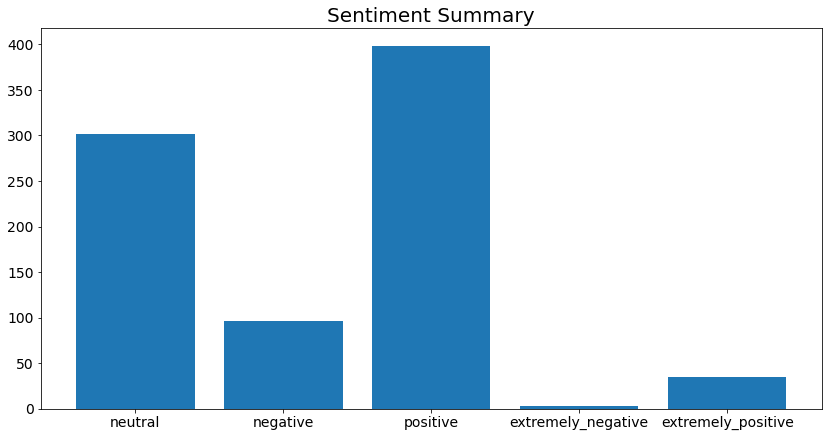

In [45]:
x_axis = ['neutral', 'negative', 'positive', 'extremely_negative', 'extremely_positive']
y_axis = [neutral, negative, positive, extremely_negative, extremely_positive]
plt.figure(figsize=(14,7))
plt.bar(x_axis, y_axis)
plt.title('Sentiment Summary', fontsize=20)
plt.show()

This graph shows the sentimentality of tweets about 'Duke' from 2022-05-15 to 2022-08-31. Among 834 tweets, most of them are classified to be positive and neutral, which means people are generally positive about 'Duke', although not necessarily towards Duke University. 